In [20]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP

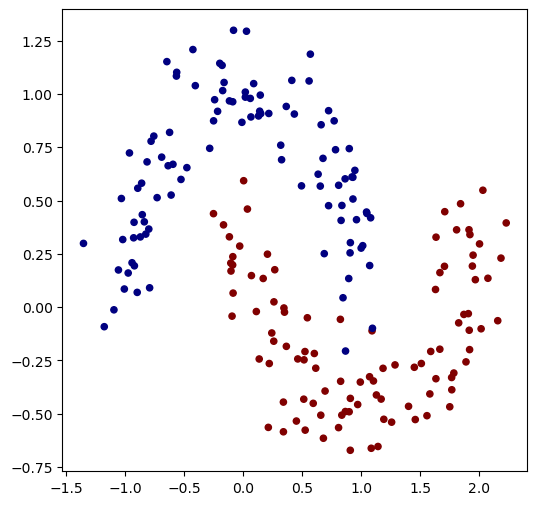

In [22]:
# make up a dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=200, noise=0.15)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(6,6))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [23]:
# initialize a model 
model = MLP(2, [32, 16, 1]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32)], Layer of [LinearNeuron(16)]]
number of parameters 641


In [26]:
# loss function
def loss(batch_size=None):
    # inline DataLoader 
    if batch_size is None:
        Xb, yb = X, y  # the whole dataset is our mini-batch
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]  # random index for sampling mini-batch
        Xb, yb = X[ri], y[ri]  # sample mini-batch
    inputs = [list(map(Value, xrow)) for xrow in Xb]  # wrap input data in a micrograd Value

    # forward the model to get scores
    scores = list(map(model, inputs))  

    losses = [(1 + -yi * scorei).relu() for yi, scorei in zip(yb, scores)]  # the SVM "max-margin" loss
    data_loss = sum(losses) * (1.0 / len(losses))  # average loss
    
    alpha = 1e-4
    reg_loss = alpha * sum((p * p for p in model.parameters())) # simple L2 regularization
    total_loss = data_loss + reg_loss  

    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]  # 0/1 loss
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss.data, acc)

2.255378044383087 0.395


In [27]:
# optimization
for k in range(100):

    # forward
    total_loss, acc = loss()

    # backward
    model.zero_grad()
    total_loss.backward()

    # update (SGD)
    learning_rate = 1.0 - 0.9 * k / 100  # learning rate annealing
    for p in model.parameters():
        p.data -= learning_rate * p.grad  # simply subtract the gradient scaled by learning rate

    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc * 100}%")

step 0 loss 2.255378044383087, accuracy 39.5%
step 1 loss 2.467735245541662, accuracy 50.0%
step 2 loss 0.478211287595419, accuracy 79.0%
step 3 loss 0.5828029541166511, accuracy 82.0%
step 4 loss 0.629683124763755, accuracy 80.5%
step 5 loss 0.32276352289520405, accuracy 88.5%
step 6 loss 0.49929744283556876, accuracy 82.5%
step 7 loss 0.26545946202893267, accuracy 89.5%
step 8 loss 0.259387219005725, accuracy 90.0%
step 9 loss 0.32356998762119116, accuracy 89.0%
step 10 loss 0.22741646157205486, accuracy 90.5%
step 11 loss 0.25997808951802737, accuracy 90.5%
step 12 loss 0.23810037777843335, accuracy 89.0%
step 13 loss 0.31856469708011714, accuracy 90.5%
step 14 loss 0.24147686705716298, accuracy 90.0%
step 15 loss 0.2689394897158488, accuracy 90.0%
step 16 loss 0.1991353222056567, accuracy 91.5%
step 17 loss 0.2011522474344298, accuracy 93.0%
step 18 loss 0.21364924673628863, accuracy 91.5%
step 19 loss 0.2941269351264747, accuracy 91.0%
step 20 loss 0.18319255782059227, accuracy 94

(-1.6710401871399896, 2.0789598128600106)

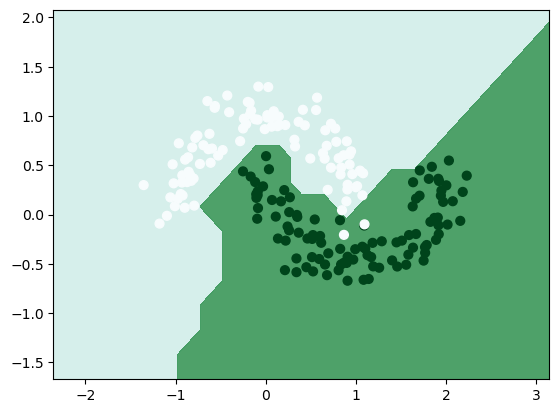

In [36]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.BuGn, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.BuGn)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())